## Mental Health Classification

The idea is to use reddit to identify text that can suggest suicide or depression tendency and see if we can correclty predict the potential tendency so we can get help. Doing this as part of a high school science project.

### Download and view data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 13 20:56:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              51W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install datasets

In [ ]:
!pip install -U accelerate

In [ ]:
!pip install -U transformers

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_metric
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer, AutoTokenizer

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


# Load and prepare datasets

**Load Datasets**

load the CSV files and you will need to combine the seperate files into a single file and then split it into Train, Validate and Test

In [ ]:
# Load datasets
def load_dataset(file_path):
    df = pd.read_csv(file_path, sep = '|')
    df.columns = ['text', 'labels']  # Assuming two columns: 'input' and 'output'
    return df

Split the data set into Train, validate and test

In [ ]:
# Split dataset
def split_dataset(df):
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    return map(Dataset.from_pandas, (train_df, val_df, test_df))

Now we load the data and complete the split

In [ ]:
# Load and split each dataset
sThread_train, sThread_val, sThread_test = split_dataset(load_dataset('tags.csv'))
dThread_train, dThread_val, dThread_test = split_dataset(load_dataset('tagd.csv'))
tThread_train, tThread_val, tThread_test = split_dataset(load_dataset('tagn.csv'))

Combine the split data sets

In [ ]:
combined_dataset = DatasetDict({
    'train': Dataset.from_dict(pd.concat([sThread_train.to_pandas(), dThread_train.to_pandas(), tThread_train.to_pandas()])),
    'validation': Dataset.from_dict(pd.concat([sThread_val.to_pandas(), dThread_val.to_pandas(), tThread_val.to_pandas()])),
    'test': Dataset.from_dict(pd.concat([sThread_test.to_pandas(), dThread_test.to_pandas(), tThread_test.to_pandas()]))
})

In [ ]:
display(combined_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 1048
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 131
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 133
    })
})

In [ ]:

#def filter_non_strings(dataset):
#    return dataset.filter(lambda example: isinstance(example['text'], str) and isinstance(example['labels'], str))
# Apply the filtering function to each split in the dataset
#filtered_dataset = DatasetDict({split: filter_non_strings(combined_dataset[split]) for split in combined_dataset.keys()})


# Setup Tokenizer and Initiatlization

Initialize the tokenizer and model

In [ ]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-base')
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenization function

In [ ]:
# Tokenization function

def tokenize_function(examples):
    model_inputs = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['labels'], padding='max_length', truncation=True, max_length=512)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs



Tokenize data sets

In [ ]:
# Tokenize datasets - combined does not work
tokenized_datasets = combined_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/1048 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3866: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/131 [00:00<?, ? examples/s]

Map:   0%|          | 0/133 [00:00<?, ? examples/s]

Training arguments

In [ ]:
# After tokenization
sample_batch = tokenized_datasets['validation']  # Adjust the slice for larger batch sizes if necessary

print(f"Shape of input_ids in a batch: {np.shape(sample_batch['input_ids'])}")
print(f"Shape of labels in a batch: {np.shape(sample_batch['labels'])}")



Shape of input_ids in a batch: (131, 512)
Shape of labels in a batch: (131, 512)


In [ ]:
# Training arguments


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4, #New change
    per_device_eval_batch_size=4, #New change
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir='./logs',
    load_best_model_at_end=True,
)

Define a function to compute accuracy

In [ ]:
# prompt: how to find the shape of the shape of the input array of the training set
display(tokenized_datasets)


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1048
    })
    validation: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 131
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 133
    })
})

In [ ]:
"""
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Convert logits to predicted token IDs
    predictions = np.argmax(logits, axis=-1).flatten()
    # Flatten the predictions and labels for comparison
    true_labels = labels.flatten()
    pred_labels = predictions.flatten()
    print("True Labels : ", true_labels)
    print("Predicted labels : ", pred_labels)
    accuracy = accuracy_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    return {
        "accuracy": accuracy,
        "recall": recall
    }

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=2).flatten()  # Fix the axis
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='weighted')  # Use 'binary' for binary classification
    return {"accuracy": accuracy, "recall": recall}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    print(f"logits shape: {type(logits)}")  # Debugging: Print logits shape
    print(f"labels shape: {labels.shape}")  # Debugging: Print labels shape

    # Ensure labels are correctly shaped for comparison
    predictions = np.argmax(logits, axis=-1).flatten()
    # Flatten arrays for metric calculations
    labels = labels.flatten()
    predictions = predictions
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)

    return {"accuracy": accuracy, "recall": recall}
"""

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Assuming logits are the first element of the tuple
    logits_shape = logits[0].shape if isinstance(logits, tuple) else logits.shape
    #print(f"logits shape: {logits_shape}")  # This will print the shape of the logits
    #print(f"labels shape: {labels.shape}")  # Continue to print labels shape

    # Proceed with your metrics calculation
    predictions = np.argmax(logits[0], axis=-1) if isinstance(logits, tuple) else np.argmax(logits, axis=-1)
    labels = labels.flatten()
    predictions = predictions.flatten()
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average='weighted', zero_division=0)

    return {"accuracy": accuracy, "recall": recall}


Initialize Trainer

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics
)

Start Training

In [ ]:
def plot_dataset_distribution(train_size, val_size, test_size):
    # Names of the datasets
    datasets = ['Training', 'Validation', 'Testing']

    # Sizes of each dataset
    sizes = [train_size, val_size, test_size]

    # Creating the bar plot
    plt.bar(datasets, sizes, color=['blue', 'orange', 'green'])

    # Adding title and labels
    plt.title('Dataset Distribution')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')

    # Display the plot
    plt.show()

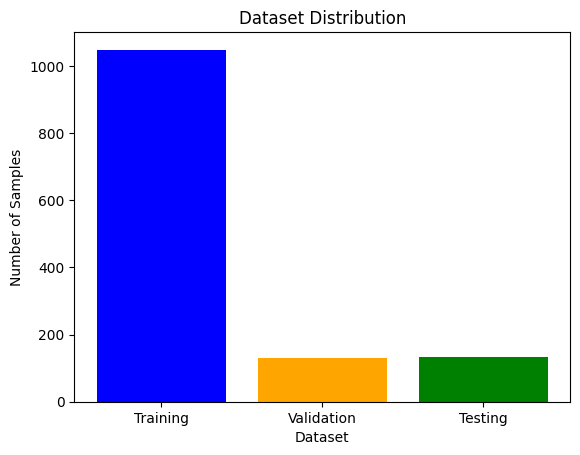

In [ ]:
# Assuming these are the sizes of your datasets
train_size = len(sThread_train) + len(dThread_train) + len(tThread_train)
val_size = len(sThread_val) + len(dThread_val) + len(tThread_val)
test_size = len(sThread_test) + len(dThread_test) + len(tThread_test)

plot_dataset_distribution(train_size, val_size, test_size)

In [ ]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Recall
1,No log,0.151793,0.997883,0.997883
2,4.031400,0.004770,0.999389,0.999389
3,4.031400,0.002771,0.999284,0.999284


logits shape: (131, 512, 32128)
labels shape: (131, 512)
logits shape: (131, 512, 32128)
labels shape: (131, 512)
logits shape: (131, 512, 32128)
labels shape: (131, 512)


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=786, training_loss=2.570472170681747, metrics={'train_runtime': 296.1665, 'train_samples_per_second': 10.616, 'train_steps_per_second': 2.654, 'total_flos': 2152877116096512.0, 'train_loss': 2.570472170681747, 'epoch': 3.0})

In [ ]:
"""
def plot_metrics(eval_results):
    metrics = ['accuracy', 'recall']
    values = [eval_results.get(metric, 0) for metric in metrics]
    plt.bar(metrics, values, color=['blue', 'green'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Performance Metrics')
    plt.ylim(0, 1)
    plt.show()
"""

def plot_metrics(eval_results):
    # Updated to match the exact keys from eval_results
    metrics = ['eval_accuracy', 'eval_recall']
    values = [eval_results.get(metric, 0) for metric in metrics]
    plt.bar(metrics, values, color=['blue', 'green'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Performance Metrics')
    plt.ylim(0, 1)  # You might adjust this if your metrics values are outside this range
    plt.xticks(rotation=45)  # Rotate labels to fit longer names
    plt.show()

Evaluate the model on the test set


In [ ]:
# Evaluate the model on the test set
test_results = trainer.evaluate(tokenized_datasets['test'])
print("Evaluation Results:", test_results)

logits shape: (133, 512, 32128)
labels shape: (133, 512)
Evaluation Results: {'eval_loss': 0.0027411128394305706, 'eval_accuracy': 0.9993244830827067, 'eval_recall': 0.9993244830827067, 'eval_runtime': 11.0334, 'eval_samples_per_second': 12.054, 'eval_steps_per_second': 3.082, 'epoch': 3.0}


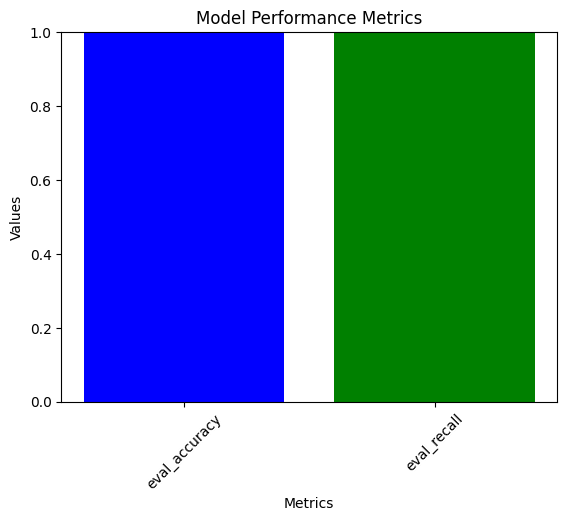

In [ ]:
# Plotting the accuracy and recall
plot_metrics(test_results)

In [ ]:
# Print the accuracy on the test set
print("Accuracy on Test Set:", test_results['eval_accuracy'])

Accuracy on Test Set: 0.9993244830827067


Sample prediction function

In [ ]:
# Sample prediction function
"""
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model.generate(inputs.input_ids, attention_mask=inputs.attention_mask)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)
"""
def predict(text):
    # Ensure the model is on the correct device (e.g., GPU if available)
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if gpu_info.find('failed') >= 0:
        device = "cpu"
    else:
        device = "cuda"
    model.to(device)

    # Prepare the inputs
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move the inputs to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate predictions
    outputs = model.generate(**inputs)

    # Decode the generated ids to get the predicted text
    predicted_label = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return predicted_label

Sample text from the test set for demonstration

In [ ]:
# Sample text from the test set for demonstration
def sample_predict(sample_text):
    predicted_label = predict(sample_text)
    print(f"Sample Text: {sample_text}")
    print(f"Predicted Label: {predicted_label}")

# Prediction accuracy

In [ ]:
prefix = 'As a psychologist, read the post on social media below and answer the question. To answer choose any one of these three conditions: suicide, depressed, normal'

In [ ]:
# Sample text from the test set for demonstration
sample_txt = "I think my life is a ticking time bomb, I can no longer stand humiliation or psychological abuse, I have financial problems, besides people have made me lose all my self-esteem, one cannot be strong if one does not have anything in life, nobody who cares For you, I only despise, I hate living, I hate existing, I feel ashamed of myself for the person I am. I would like to fulfill my dream of falling asleep and not waking up again without feeling pain"
sample_text = prefix + sample_txt
predicted_label = sample_predict(sample_text)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Sample Text: As a psychologist, read the post on social media below and answer the question. To answer choose any one of these three conditions: suicide, depressed, normalI think my life is a ticking time bomb, I can no longer stand humiliation or psychological abuse, I have financial problems, besides people have made me lose all my self-esteem, one cannot be strong if one does not have anything in life, nobody who cares For you, I only despise, I hate living, I hate existing, I feel ashamed of myself for the person I am. I would like to fulfill my dream of falling asleep and not waking up again without feeling pain
Predicted Label: depression


In [ ]:
sample_txt = "Ive been struggling a lot today with my depression. I feel like I give everyone so much of me that there’s not enough left for me. I feel like I can’t even get out of bed because I feel burnt out and I can’t handle simply smiling. I have been pushing this feeling down for months. Today it seems that I’ve lost my strength. I wish I could be happy but I think I gave it all away. I support and cheer on so many people but when I look around I don’t see people doing it for me. I feel like if I’m not hyping people up and being an “amazing friend” then I’m a burden. Like I’m not allowed to have bad days 2 days in a row or else I’m annoying. My husband is going through some stuff of his own so I isolate from him. I feel like everything is too much and I feel guilty for not having the energy to do anything but lay in bed all day. I just don’t know how long I can go on feeling like this."
sample_text = prefix + sample_txt
predicted_label = sample_predict(sample_text)

Sample Text: As a psychologist, read the post on social media below and answer the question. To answer choose any one of these three conditions: suicide, depressed, normalIve been struggling a lot today with my depression. I feel like I give everyone so much of me that there’s not enough left for me. I feel like I can’t even get out of bed because I feel burnt out and I can’t handle simply smiling. I have been pushing this feeling down for months. Today it seems that I’ve lost my strength. I wish I could be happy but I think I gave it all away. I support and cheer on so many people but when I look around I don’t see people doing it for me. I feel like if I’m not hyping people up and being an “amazing friend” then I’m a burden. Like I’m not allowed to have bad days 2 days in a row or else I’m annoying. My husband is going through some stuff of his own so I isolate from him. I feel like everything is too much and I feel guilty for not having the energy to do anything but lay in bed all d

In [ ]:
# Sample text from the test set for demonstration
sample_txt = "ars waging everywhere, evil politicians, heartless billionaires, inexplicably getting rejected from every job you apply to as a degree holder when you’re trying your best... So can someone tell me why is this bullshit existence worth it?"
sample_text = prefix + sample_txt
predicted_label = sample_predict(sample_text)

Sample Text: As a psychologist, read the post on social media below and answer the question. To answer choose any one of these three conditions: suicide, depressed, normalars waging everywhere, evil politicians, heartless billionaires, inexplicably getting rejected from every job you apply to as a degree holder when you’re trying your best... So can someone tell me why is this bullshit existence worth it?
Predicted Label: suicide


In [ ]:
def plot_dataset_distribution(train_size, val_size, test_size):
    # Names of the datasets
    datasets = ['Training', 'Validation', 'Testing']

    # Sizes of each dataset
    sizes = [train_size, val_size, test_size]

    # Creating the bar plot
    plt.bar(datasets, sizes, color=['blue', 'orange', 'green'])

    # Adding title and labels
    plt.title('Dataset Distribution')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')

    # Display the plot
    plt.show()

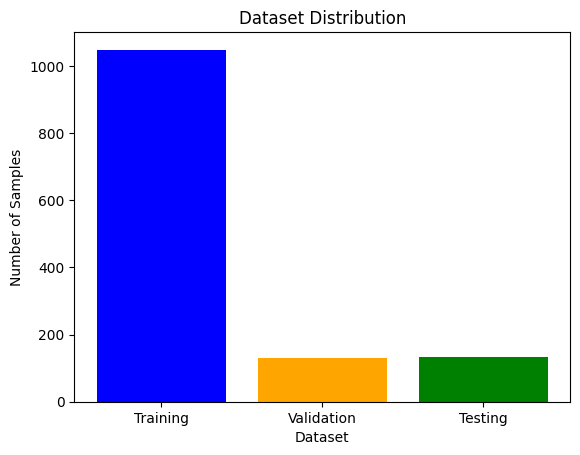

In [ ]:
# Assuming these are the sizes of your datasets
train_size = len(sThread_train) + len(dThread_train) + len(tThread_train)
val_size = len(sThread_val) + len(dThread_val) + len(tThread_val)
test_size = len(sThread_test) + len(dThread_test) + len(tThread_test)

plot_dataset_distribution(train_size, val_size, test_size)